# Project-4 : Advance lane Finding


## Read Image

In [111]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle

## Camera Calibration 




In [112]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

#print(" objp = ",objp)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        #cv2.imshow('img', img)
        #cv2.waitKey(500)
    else :
        print("Not used- ",fname)



Not used-  camera_cal/calibration5.jpg
Not used-  camera_cal/calibration4.jpg
Not used-  camera_cal/calibration1.jpg


## Undistort

(720, 1280)


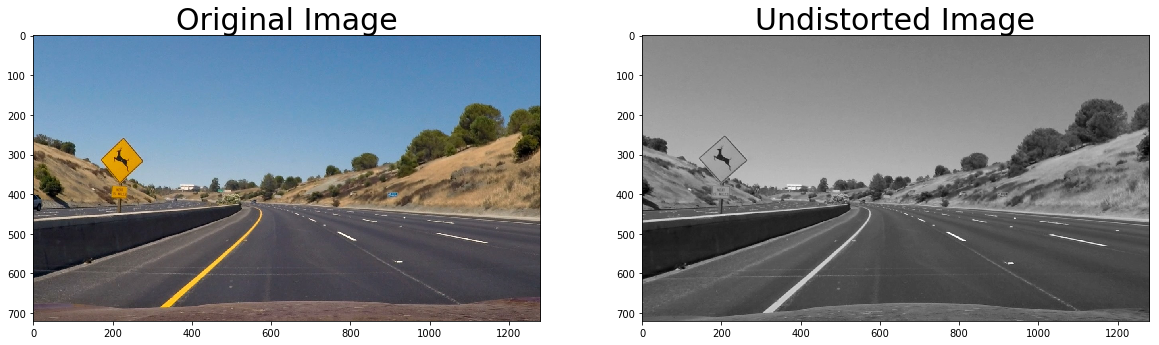

In [113]:
import pickle
img = mpimg.imread('test_images/test2.jpg')
#img = mpimg.imread('camera_cal/calibration2.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#plt.imshow(gray, cmap = 'gray')
print(gray.shape)

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

undistorted = cv2.undistort(gray, mtx, dist, None, mtx)
cv2.imwrite('output_images/test_undist.jpg',undistorted)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "output_images/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img, cmap = 'gray')
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted, cmap = 'gray')
ax2.set_title('Undistorted Image', fontsize=30)
plt.savefig("./undistorted_test.jpg")

In [114]:
# definition
def plot_2(img1,img2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img1,)
    ax2.imshow(img2)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

def rgb_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def bgr_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

##  Color and Gradient Thresholding  

In [115]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x' :
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize = sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F,0,1, ksize = sobel_kernel)
    else :
        return None
    
    abs_sobel = np.absolute(sobel)
    
    scaled_sobel = np.uint8(255* (abs_sobel)/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1] )] = 1
    
    return binary_output

def hls_threshold(img, color_channel = 's', thresh=(0,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    
    binary = np.zeros_like(S)
    
    if color_channel == 's':        
        binary[(S > thresh[0]) & (S <= thresh[1])] = 1
        
    elif color_channel == 'h':        
        binary[(H > thresh[0]) & (H <= thresh[1])] = 1
        
    elif color_channel == 'l':        
        binary[(L > thresh[0]) & (L <= thresh[1])] = 1
        
    return binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Calculate the magnitude 
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    # 5) Create a binary mask where mag thresholds are met
    # 6) Return this mask as your binary_output image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F,0,1)
    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    abs_sobel = np.sqrt(sobelx**2 + sobely**2  )
    
    scaled_sobel = np.uint8(255* (abs_sobel)/np.max(abs_sobel))
    
    binary_output = np.zeros_like(scaled_sobel)
    
    binary_output[(scaled_sobel > mag_thresh[0]) & (scaled_sobel < mag_thresh[1] )] = 1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    # 5) Create a binary mask where direction thresholds are met
    # 6) Return this mask as your binary_output image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1,0, ksize = sobel_kernel )
    sobely = cv2.Sobel(gray,cv2.CV_64F, 0,1, ksize = sobel_kernel)
    print("Gray Shape", gray.shape)
    print("Sobel Shape", sobelx.shape)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    dir_grad = np.arctan2(abs_sobely, abs_sobelx)
    binary_output = np.zeros_like(abs_sobelx)
    binary_output[(dir_grad > thresh[0]) & (dir_grad<thresh[1])] = 1

    return binary_output

## Cropping Region of Interest

In [116]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

## Printing Radius of Curvature

In [117]:
def print_roc(image, left_fit, right_fit):
    y = image.shape[0]-1
    
    left_curverad = ((1 + (2*left_fit[0]*y + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    #print(left_curverad, left_curverad)
    
    avg_roc = np.int32((left_curverad+left_curverad)/2)
    
    font = cv2.FONT_HERSHEY_COMPLEX
    
    xm_per_pix = 3.7/700
    img_mid = img.shape[1] / 2
     
    
    
    a = left_fit[0]
    b = left_fit[1]
    c = left_fit[2]
    
    left_line_base = (a*y**2)+(b*y)+c
    
    a = right_fit[0]
    b = right_fit[1]
    c = right_fit[2]
    
    right_line_base = (a*y**2)+(b*y)+c
    
    lane_centre = (left_line_base+right_line_base)/2
    dist_center = (lane_centre - img_mid) * xm_per_pix
    
    pos = "left" if dist_center >= 0 else "right"
    pos_text = "{} m {} of center".format(abs(round(dist_center,2)),pos)

    cv2.putText(image, pos_text, (10,50), font, 1,(255,255,255),2)
    
    
    roc_text = "Radius of Curvature: {}(m)".format(avg_roc)
    cv2.putText(image, roc_text, (10,100), font, 1,(255,255,255),2)
    #res =np.dstack((perspective_img,pt.inverse_transform(perspective_img),perspective_img))*255
    #result = cv2.addWeighted(undistorted_img, 1, res, 2, 0)
    return image
    
    
    
    
    

## MyVideoProcessor Class

In [118]:
class MyVideoProcessor():
    
    left_lane = []
    right_lane = []
    avg_left = None
    avg_right = None
    
    left_fit = None
    right_fit = None
    
    first = True
    
    
    
    def sliding_window(self,binary_warped):
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        
        if not self.first :
            
            nonzero = binary_warped.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            margin = 100
            left_lane_inds = ((nonzerox > (self.left_fit[0]*(nonzeroy**2) + self.left_fit[1]*nonzeroy + 
            self.left_fit[2] - margin)) & (nonzerox < (self.left_fit[0]*(nonzeroy**2) + 
            self.left_fit[1]*nonzeroy + self.left_fit[2] + margin))) 

            right_lane_inds = ((nonzerox > (self.right_fit[0]*(nonzeroy**2) + self.right_fit[1]*nonzeroy + 
            self.right_fit[2] - margin)) & (nonzerox < (self.right_fit[0]*(nonzeroy**2) + 
            self.right_fit[1]*nonzeroy + self.right_fit[2] + margin)))  

            # Again, extract left and right line pixel positions
            leftx = nonzerox[left_lane_inds]
            lefty = nonzeroy[left_lane_inds] 
            rightx = nonzerox[right_lane_inds]
            righty = nonzeroy[right_lane_inds]
            # Fit a second order polynomial to each
            self.left_fit = np.polyfit(lefty, leftx, 2)
            self.right_fit = np.polyfit(righty, rightx, 2)
            
            
            
            
        else:
            self.first = False
            AVG_N = 10
            # Assuming you have created a warped binary image called "binary_warped"
            # Take a histogram of the bottom half of the image
            histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)   ## shape[0]//2
            
            # Find the peak of the left and right halves of the histogram
            # These will be the starting point for the left and right lines
            midpoint = np.int(histogram.shape[0]//2)
            leftx_base = np.argmax(histogram[:midpoint])
            rightx_base = np.argmax(histogram[midpoint:]) + midpoint

            # Choose the number of sliding windows
            nwindows = 9
            # Set height of windows
            window_height = np.int(binary_warped.shape[0]//nwindows)
            # Identify the x and y positions of all nonzero pixels in the image
            nonzero = binary_warped.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Current positions to be updated for each window
            leftx_current = leftx_base
            rightx_current = rightx_base
            # Set the width of the windows +/- margin
            margin = 100
            # Set minimum number of pixels found to recenter window
            minpix = 50
            # Create empty lists to receive left and right lane pixel indices
            left_lane_inds = []
            right_lane_inds = []

            # Step through the windows one by one
            for window in range(nwindows):
                # Identify window boundaries in x and y (and right and left)
                win_y_low = binary_warped.shape[0] - (window+1)*window_height
                win_y_high = binary_warped.shape[0] - window*window_height
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin
                # Draw the windows on the visualization image
                #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
                #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 

                #plt.imshow(out_img,cmap = 'gray')

                # Identify the nonzero pixels in x and y within the window
                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
                # Append these indices to the lists
                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)
                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_left_inds) > minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                if len(good_right_inds) > minpix:        
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

            # Concatenate the arrays of indices
            #print("left_lane_inds before",len(left_lane_inds))

            left_lane_inds = np.concatenate(left_lane_inds)
            #print("left_lane_inds after",left_lane_inds.shape) 



            right_lane_inds = np.concatenate(right_lane_inds)

            # Extract left and right line pixel positions
            leftx = nonzerox[left_lane_inds]
            lefty = nonzeroy[left_lane_inds] 
            rightx = nonzerox[right_lane_inds]
            righty = nonzeroy[right_lane_inds] 

            # Fit a second order polynomial to each
            self.left_fit = np.polyfit(lefty, leftx, 2)
            self.right_fit = np.polyfit(righty, rightx, 2)
            out_img = np.uint8(out_img)

            #plot_2(binary_warped, out_img)
            #plt.imsave('./figure2.jpg',out_img)

        #print(type(self.left_lane))
        self.left_lane.append(self.left_fit)
        self.right_lane.append(self.right_fit)

        #print("self.left_fit",left_fit)
        #print("self.left_lane",self.left_lane)

        self.avg_left = np.mean(np.asarray(self.left_lane)[-10:,:], axis= 0)
        self.avg_right = np.mean(np.asarray(self.right_lane)[-10:,:], axis= 0)

        #VISUALIZE LANE LINES
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = self.avg_left[0]*ploty**2 + self.avg_left[1]*ploty + self.avg_left[2]
        right_fitx = self.avg_right[0]*ploty**2 + self.avg_right[1]*ploty + self.avg_right[2]        # CHANGED

        #out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        #out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        #plt.imshow(out_img)
        #plt.plot(left_fitx, ploty, color='yellow')
        #plt.plot(right_fitx, ploty, color='yellow')
        #plt.xlim(0, 1280)
        #plt.ylim(720, 0)

        #VISUALIZE IN LANE LINES IN GREEN
        window_img = np.zeros_like(out_img)
        left_line = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        right_line = np.array([np.flipud(np.transpose(np.vstack([right_fitx,ploty])))])
        line_pts = np.hstack((left_line, right_line))
        cv2.fillPoly(window_img, np.int_([line_pts]), (0,255, 0))

        #plt.imshow(window_img)
        #plot_two_images(img, window_img)
        #result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        #result = result / np.max(result) *255

        return window_img
    
    
    def pipeline(self,img):

        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        # Undistort
        dist_pickle = pickle.load( open( "output_images/wide_dist_pickle.p", "rb" ) )
        mtx = dist_pickle["mtx"]
        dist = dist_pickle["dist"]
        
        undistorted = cv2.undistort(gray, mtx, dist, None, mtx)
        
        # Transform
        src = np.float32([[285,670],[1017,670],[683,450],[596,450]])
        dst = np.float32([[250,700],[950,700],[950,0],[250,0]])
        
        
        M = cv2.getPerspectiveTransform(src,dst)
        Minv = cv2.getPerspectiveTransform(dst,src)
        
        warped_straight = cv2.warpPerspective(undistorted, M, (gray.shape[::-1]) , flags=cv2.INTER_LINEAR)
        
        #cv2.polylines(img,np.array([src],dtype = np.int32),True,(0,255,0),thickness=5)
        #cv2.polylines(warped_straight,np.array([dst],dtype = np.int32),True,(0,0,255),thickness=10)
    
        #plot_2(img, warped_straight)
        #plt.savefig("./tranform_straight.jpg")
        #Thresholding
        ksize = 3
        gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(10, 180))
        s_binary = hls_threshold(img, color_channel = 's', thresh=(60,190))

        
        #plot_2( s_binary,gradx)    
        combined = np.zeros_like(s_binary)
        combined[(s_binary == 1) | (gradx==1)] = 1
        
        #plt.imshow(combined, cmap = 'gray')
        #plt.savefig("./thresholding.jpg")
        # REGION OF INTEREST
        MIN_Y  = 350
        vertices = np.array( [[[100,img.shape[0]],[600,MIN_Y],[800,MIN_Y],[1200,img.shape[0]]]], dtype=np.int32 )
        
        combined = region_of_interest(combined,vertices)
        
        #plot_2(img, combined)
        warped = cv2.warpPerspective(combined, M, (gray.shape[::-1]) , flags=cv2.INTER_LINEAR)
        #warped  = np.uint8(np.dstack((warped,warped,warped)) * 255)
        #print("warped.shape",np.max(warped))
        
        #plt.imshow(warped, cmap = 'gray')
        #plt.savefig("./perspective_transform.jpg")
        #Sliding Window
        window_img = self.sliding_window(warped)
        
        
        #Inverse Transform
        final_warped = cv2.warpPerspective(window_img, Minv, ((window_img.shape[1],window_img.shape[0])) , flags=cv2.INTER_LINEAR)

        #plot_2(img, final_warped)
        #Final Image

        final_image = cv2.addWeighted(img, 1, final_warped, 0.3, 0)
        final_image = np.uint8(final_image/np.max(final_image)*255)

        #plot_2(img, final_image)
        #plot_2(final_image,img)
        print_roc(final_image, self.avg_left, self.avg_right)
        
        return final_image





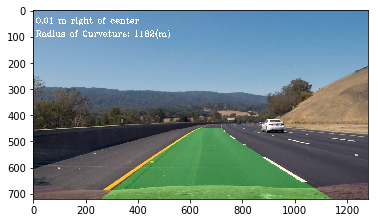

In [119]:
# TRY ON SAMPLE IMAGES
#img = plt.imread("./test_images/straight_lines1.jpg")
img = plt.imread("./test_images/test3.jpg")
myVideoProcessor = MyVideoProcessor()
result = myVideoProcessor.pipeline(img)
plt.imshow(result)
plt.savefig("./result.jpg")

## MAKE VIDEO

In [120]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


video_output = './project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
myVideoProcessor = MyVideoProcessor()
clip1 = VideoFileClip("project_video.mp4")
easy_clip = clip1.fl_image(myVideoProcessor.pipeline) #NOTE: this function expects color images!!
%time easy_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ./project_video_output.mp4
[MoviePy] Writing video ./project_video_output.mp4



100%|█████████▉| 1260/1261 [03:42<00:00,  5.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_output.mp4 

CPU times: user 4min 23s, sys: 42.1 s, total: 5min 5s
Wall time: 3min 43s
